In [56]:
import yfinance as yf
import matplotlib.pyplot as plt

In [57]:
sp500 = yf.Ticker("^GSPC")

In [58]:
sp500 = sp500.history(period="max")
#sp500

In [59]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-06-27 00:00:00-04:00', '2025-06-30 00:00:00-04:00',
               '2025-07-01 00:00:00-04:00', '2025-07-02 00:00:00-04:00',
               '2025-07-03 00:00:00-04:00', '2025-07-07 00:00:00-04:00',
               '2025-07-08 00:00:00-04:00', '2025-07-09 00:00:00-04:00',
               '2025-07-10 00:00:00-04:00', '2025-07-11 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24497, freq=None)

<Axes: xlabel='Date'>

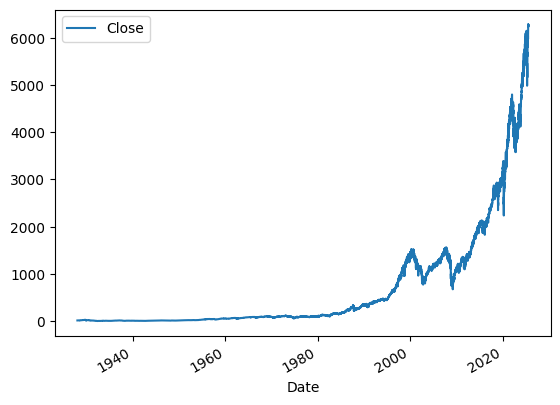

In [60]:
sp500.plot.line(y="Close", use_index=True)

In [61]:
# Cleaning data
del sp500["Dividends"]
del sp500["Stock Splits"]

In [62]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
#sp500

In [63]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
#sp500

In [64]:
sp500 = sp500.loc["1990-01-01":].copy()
#sp500

In [65]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [67]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [68]:
precision_score(test["Target"], preds)

0.5657894736842105

In [69]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

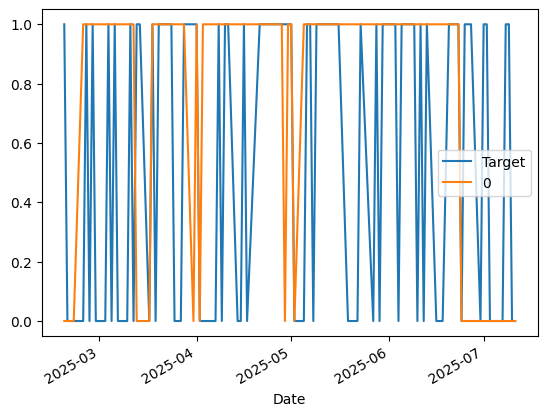

In [70]:
combined.plot()

In [71]:
#Building a backtesting system
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)  # Fixed: use test index
    combined = pd.concat([test["Target"], preds], axis=1)
    combined.columns = ["Target", "Predictions"]
    return combined

In [72]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [73]:
predictions = backtest(sp500, model, predictors)

In [74]:
predictions["Predictions"].value_counts()

Predictions
0    3782
1    2665
Name: count, dtype: int64

In [76]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5298311444652908